In [20]:
#Code was heavily based on this implementation: CBIR-NewCode-CNN Model on Kaggle that can be found on this website
#https://www.kaggle.com/code/sjha999/cbir-newcode-cnn-model

In [1]:
# Importing Necessary Libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
root_dir = "./SparkData"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

def GetDatasetSize(path, classes):
    num_of_image = {}
    for cls in classes:
        # Counting the Number of Files in the Folder
        num_of_image[cls] = len(os.listdir(os.path.join(path, cls)));
    return num_of_image;

print(GetDatasetSize(root_dir, classes));

{'Dyskeratotic': 813, 'Koilocytotic': 825, 'Metaplastic': 793, 'Parabasal': 787, 'Superficial-Intermediate': 831}


### Split the Dataset such that we have
* 70% for Train Data
* 15% for Validation Data
* 15% for Testing Data

In [3]:
# Function for Creating Train / Validation / Test folders (One time use Only)

def TrainValTestSplit(root_dir, classes_dir, val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('train/' + cls)
        os.makedirs('val/' + cls)
        os.makedirs('test/' + cls)

        # Folder to copy images from
        src = os.path.join(root_dir, cls);

        # Spliting the Files in the Given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls,':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'test/' + cls)
        print();
        

# Preforming Train / Validation / Test Split
root_dir = "./SparkData"               # Dataset Root Folder
classes_dir = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
TrainValTestSplit(root_dir, classes_dir);

Dyskeratotic :
Total images:  813
Training:  569
Validation:  122
Testing:  122

Koilocytotic :
Total images:  825
Training:  577
Validation:  124
Testing:  124

Metaplastic :
Total images:  793
Training:  555
Validation:  119
Testing:  119

Parabasal :
Total images:  787
Training:  550
Validation:  118
Testing:  119

Superficial-Intermediate :
Total images:  831
Training:  581
Validation:  125
Testing:  125



### Building Model 


In [4]:
# Importing Keras for Image Classification
import tensorflow as tf 
import tensorflow.keras
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model

In [5]:
# CNN Model 

model = Sequential() 

# Convolutional Layer with input shape (64,64,3)
model.add(Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=(75,75,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))



model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=5, activation='sigmoid'))

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
#               loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 35, 35, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       7

### Preparing data using data generator 

In [6]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [7]:
train_data = train_datagen.flow_from_directory(directory= "./train", target_size=(75, 75), batch_size=100, class_mode = 'categorical')

Found 2832 images belonging to 5 classes.


In [8]:
train_data.class_indices

{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [9]:
val_data = val_datagen.flow_from_directory(directory= "./val", target_size=(75, 75), batch_size=100, class_mode = 'categorical')

Found 608 images belonging to 5 classes.


In [10]:
test_data = test_datagen.flow_from_directory(directory= "./test", target_size=(75, 75), batch_size=100, class_mode = 'categorical')

Found 609 images belonging to 5 classes.


In [11]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="cervical_cancer_best_model.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

In [12]:
# Fitting the Model
cnn = model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
28/28 [==============================] - ETA: 0s - loss: 1.4065 - accuracy: 0.3591
Epoch 1: val_accuracy improved from -inf to 0.44500, saving model to cervical_cancer_best_model.hdf5
28/28 [==============================] - 7s 232ms/step - loss: 1.4065 - accuracy: 0.3591 - val_loss: 1.2538 - val_accuracy: 0.4450
Epoch 2/32
28/28 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.5307
Epoch 2: val_accuracy improved from 0.44500 to 0.52167, saving model to cervical_cancer_best_model.hdf5
28/28 [==============================] - 7s 242ms/step - loss: 1.1110 - accuracy: 0.5307 - val_loss: 1.0973 - val_accuracy: 0.5217
Epoch 3/32
28/28 [==============================] - ETA: 0s - loss: 0.9888 - accuracy: 0.6193
Epoch 3: val_accuracy improved from 0.52167 to 0.68333, saving model to cervical_cancer_best_model.hdf5
28/28 [==============================] - 6s 228ms/step - loss: 0.9888 - accuracy: 0.6193 - val_loss: 0.8823 - val_accuracy: 0.6833
Epoch 4/32
28/28

In [13]:
# Loading the Best Fit Model 
model = load_model("./cervical_cancer_best_model.hdf5")

### Model Accuracy

In [14]:
# Checking the Accuracy of the Model 
accuracy = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy*100} %")

The accuracy of your model is = 90.96879959106445 %


In [15]:
h =  cnn.history;
h.keys();

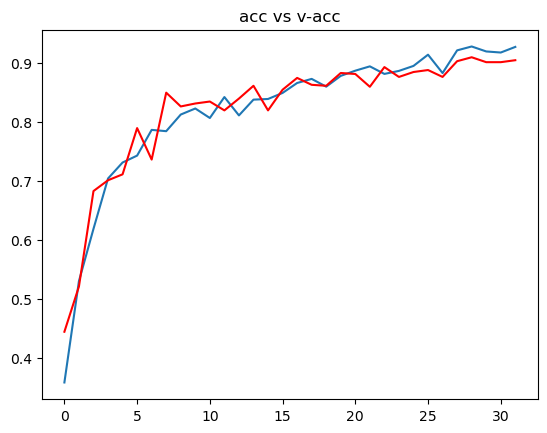

In [16]:
# Ploting Accuracy In Training Set & Validation Set

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

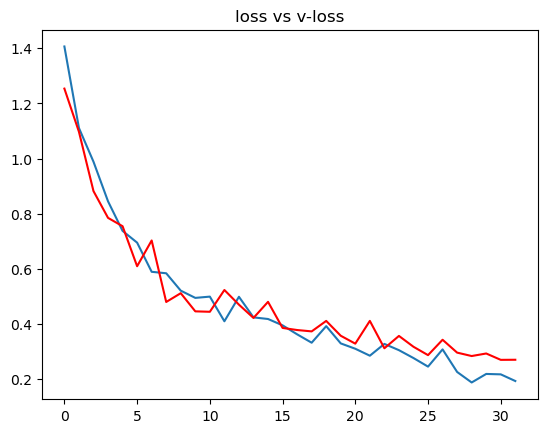

In [17]:
# Ploting Loss In Training Set & Validation Set

plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

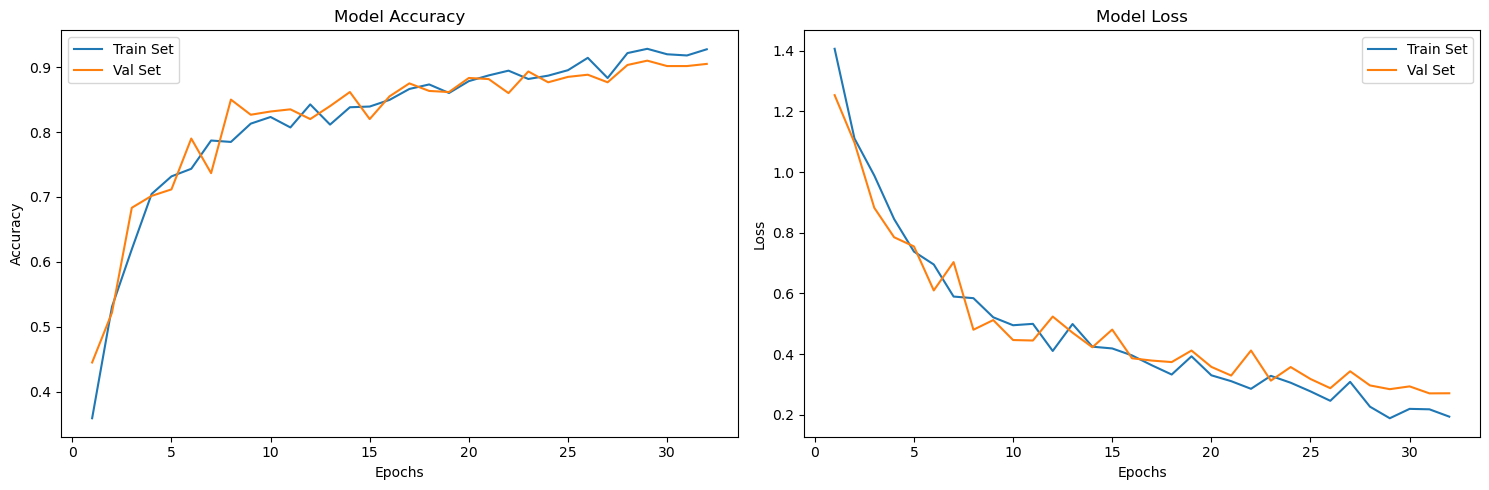

In [18]:
# Plot model performance
acc = cnn.history['accuracy']
val_acc = cnn.history['val_accuracy']
loss = cnn.history['loss']
val_loss = cnn.history['val_loss']
epochs_range = range(1, len(cnn.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [19]:
acc

[0.3590776026248932,
 0.5307466983795166,
 0.6193264722824097,
 0.7046120166778564,
 0.7316983938217163,
 0.7434114217758179,
 0.7869692444801331,
 0.784773051738739,
 0.8129575252532959,
 0.8232064247131348,
 0.8071010112762451,
 0.8426061272621155,
 0.8114933967590332,
 0.8382142782211304,
 0.8393118381500244,
 0.8495607376098633,
 0.8663982152938843,
 0.8733528256416321,
 0.8601756691932678,
 0.8784773349761963,
 0.8872621059417725,
 0.8945827484130859,
 0.8817716240882874,
 0.8868960738182068,
 0.8953148126602173,
 0.9143484830856323,
 0.88323575258255,
 0.9216691255569458,
 0.9282577037811279,
 0.9198389649391174,
 0.9180088043212891,
 0.9275256395339966]